Code taken from:
https://en.wikipedia.org/wiki/Lorenz_system

In [5]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [6]:
def Lorenz(state,t):
  # unpack the state vector
  x = state[0]
  y = state[1]
  z = state[2]

  # these are our constants
  sigma = 9.0
  rho = 20.0
  beta = 8.0/3.0

  # compute state derivatives
  xd = sigma * (y-x)
  yd = (rho-z)*x - y
  zd = x*y - beta*z

  # return the state derivatives
  return [xd, yd, zd]

In [15]:
state0 = [2.0, 3.0, 4.0]
t = np.arange(0.0, 30.0, 0.01)

state = odeint(Lorenz, state0, t)

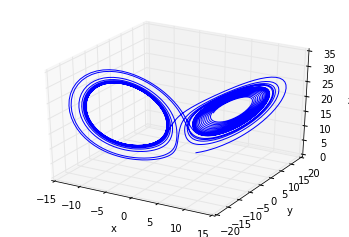

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(state[:,0],state[:,1],state[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()